# Ring resonator

We simulate the propagation of an electromagnetic TM-Wave through a ring resonator device using the [dual cell method](https://ngsolve.github.io/dcm/intro.html) add on for [NGSolve](https://ngsolve.org).

The desired geometry is sketched below, where the horizontal waveguides are supposed to be unbounded.

![title](../images/ring_resonator_geo.png)

The governing equations for the scalar field $p: [0,T]\to H^1(\Omega)$ and the vector field $u: [0,T]\to L^2(\Omega)^2$ are

$$
\begin{aligned}
\partial_t \int_\Omega u \cdot v  &= -\int_\Omega \nabla p\cdot v \\
\partial_t \int_\Omega pq &= \int_\Omega u \cdot \nabla q +\int_\Omega fq
\end{aligned}
$$
for all test functions $q\in H^1(\Omega)$, $v\in L^2(\Omega)^2$ and a source $f: [0,T]\to L^2(\Omega)$.



To simulate an unbounded domain we surround the domain $\Omega$ by an absorbing layer.

![title](../images/ring_resonator_geo_pml.png)

The damped [time-domain system](https://markuswess.github.io/waves/pmls/time-domain.html) to be solved is now

$$
\begin{aligned}
\partial_t \int_\Omega u \cdot v  &= -\int_\Omega \nabla p\cdot v -\alpha\int_{\Omega_{tb}\cup\Omega_{lr}}u \cdot n n^\top v +\alpha\int_{\Omega_{tb}\cup\Omega_{lr}}u \cdot(\mathbf I-n n^\top)v +\alpha\int_{\Omega_{tb}\cup\Omega_{lr}}\hat u\cdot\left(\mathbf I- nn^\top\right)v  +\int_{\Omega_{\mathrm{int}}}fv \\
\partial_t \int_\Omega pq &= \int_\Omega u \cdot \nabla q-\alpha\int_{\Omega_{tb}\cup\Omega_{lr}}pq-2\alpha\int_{\Omega_c}pq+\alpha\int_{\Omega_c}\hat p q\\
\partial_t \int_\Omega \hat p\hat q &=-\alpha\int_{\Omega_c}p\hat q\\
\partial_t \int_\Omega \hat u\cdot \hat v &=-\alpha\int_{\Omega_{tb}\cup\Omega_{lr}}\hat u\cdot\hat v-\alpha\int_{\Omega_{tb}\cup\Omega_{lr}}u \cdot\hat v
\end{aligned}
$$

where $\alpha > 0$ is the damping parameter and $n$ is the direction of the PML damping, i.e.:
$$
n = \begin{cases}
(1,0)^\top,& \Omega_{lr},\\
(0,1)^\top,& \Omega_{tb}.
\end{cases}
$$


## Generating the geometry

The geometry is given by two parallel wires with a ring-shaped one in between. It is generated in NGSolve using the `SplineGeometry`.

In [3]:
from ngsolve import *
import netgen.geom2d as gm
from ngsolve.webgui import Draw
import matplotlib.pyplot as pl;
import numpy as np
import dualcellspaces as dcs


geo = gm.SplineGeometry()


# geometry parameters
xneg  =-0.43
xpos  = 0.43
yneg  =-0.48
ypos  = 0.48

wslab = 0.04
cringx = 0.0
cringy = 0.0
rring = 0.4
gap   = 0.005


pntx = [xneg,xpos]
pnty = [yneg,-rring-gap-wslab,-rring-gap,rring+gap,rring+gap+wslab,ypos]


pts = []
for yi in pnty:
    for xi in pntx:
        pts.append (geo.AddPoint(xi,yi))


### geometry #######################################################
#inner rects
geo.Append (["line", pts[0], pts[1]], leftdomain=1, rightdomain=0)
geo.Append (["line", pts[1], pts[3]], leftdomain=1, rightdomain=0)
geo.Append (["line", pts[3], pts[2]], leftdomain=1, rightdomain=2)
geo.Append (["line", pts[2], pts[0]], leftdomain=1, rightdomain=0)

geo.Append (["line", pts[3], pts[5]], leftdomain=2, rightdomain=0,bc="normal_wg_rightbottom")
geo.Append (["line", pts[5], pts[4]], leftdomain=2, rightdomain=3)
geo.Append (["line", pts[4], pts[2]], leftdomain=2, rightdomain=0,bc="normal_wg_leftbottom")

geo.Append (["line", pts[5], pts[7]], leftdomain=3, rightdomain=0)
geo.Append (["line", pts[7], pts[6]], leftdomain=3, rightdomain=4)
geo.Append (["line", pts[6], pts[4]], leftdomain=3, rightdomain=0)

geo.Append (["line", pts[7], pts[9]], leftdomain=4, rightdomain=0,bc="normal_wg_righttop")
geo.Append (["line", pts[9], pts[8]], leftdomain=4, rightdomain=5)
geo.Append (["line", pts[8], pts[6]], leftdomain=4, rightdomain=0,bc="normal_wg_lefttop")

geo.Append (["line", pts[9], pts[11]], leftdomain=5, rightdomain=0)
geo.Append (["line", pts[11], pts[10]], leftdomain=5, rightdomain=0)
geo.Append (["line", pts[10], pts[8]], leftdomain=5, rightdomain=0)

geo.AddCircle(c=(cringx,cringy), r=rring, leftdomain=6, rightdomain=3)
geo.AddCircle(c=(cringx,cringy), r=rring-wslab, leftdomain=7, rightdomain=6)

for i in (1,3,5,7):
    geo.SetMaterial(i, "air")
for i in (2,4,6):
    geo.SetMaterial(i, "eps_nine")


This geometry may be meshed, resulting in the following triangulation:

In [4]:
mesh_inner = Mesh(geo.GenerateMesh(maxh=0.1))
mesh_inner.Curve(4)
Draw(mesh_inner);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

### PML geometry

However, as we also want to use perfectly matched layers to simulate an unbounded domain, we add the PML domains to the mesh as follows

In [5]:
pmlwidth = 0.1
maxh = 0.03
order = 2

data = geo.CreatePML(pmlwidth)
normals = data["normals"]


mesh = Mesh(geo.GenerateMesh(maxh=maxh))
mesh.Curve(order)
Draw(mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

The function `CreatePML` has added the perfectly matched layer domains to our given interior mesh:

In [6]:
for bd in mesh_inner.GetBoundaries(): print(bd)

default
default
default
default
normal_wg_rightbottom
default
normal_wg_leftbottom
default
default
default
normal_wg_righttop
default
normal_wg_lefttop
default
default
default
default
default
default
default
default
default
default
default


In [7]:
for mat in mesh.GetMaterials(): print(mat)

air
eps_nine
air
eps_nine
air
eps_nine
air
pml_default
pml_corner
pml_default_duplicate_1
pml_normal_wg_rightbottom
pml_default_duplicate_2
pml_normal_wg_righttop
pml_default_duplicate_3
pml_corner
pml_default_duplicate_4
pml_corner
pml_default_duplicate_5
pml_normal_wg_lefttop
pml_default_duplicate_6
pml_normal_wg_leftbottom
pml_default_duplicate_7
pml_corner


## Source

We define the source field on the boundary `normal_wg_lefttop`:

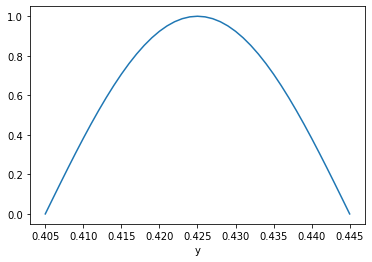

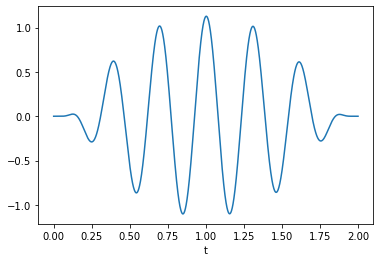

In [8]:
wavelength = 1.542
fcen       = 5/wavelength
tpeak      = 1


sourcey = CoefficientFunction(  sin(  (pi/wslab)*(y-rring-gap)  )  )

fes_facet = FacetFESpace(mesh, order=order+3)
gfsource = GridFunction(fes_facet)

gfsource.Set(sourcey,definedon=mesh.Boundaries("normal_wg_lefttop"))

def t_envelope(t):
    if abs((t-tpeak)/tpeak) < 1 :
        return 2*exp(1)/sqrt(pi)*np.sin(2*pi*fcen*t)*np.exp (-1/(1-((t-tpeak)/tpeak)**2))
    else: return 0.
    

delta = 0.001
ys = np.arange(rring+gap,rring+gap+wslab+delta,delta)

pl.xlabel('y');
pl.plot(ys,sourcey(mesh(0,ys)));

ts = np.arange(0,2,delta)

pl.figure();
pl.xlabel('t');
pl.plot(ts,[t_envelope(t) for t in ts]);

## Coefficients

We set the material parameters in the waveguides and the background medium:

In [9]:
eps_r = {"air" : 1,
         "eps_nine" : 3**3}

for mat in mesh.GetMaterials():
    if mat.startswith("pml_normal_wg"):
        eps_r[mat] = eps_r["eps_nine"]

for mat in mesh.GetMaterials():
    if mat not in eps_r:
        eps_r[mat] = eps_r["air"]


eps = CF([eps_r[mat] for mat in mesh.GetMaterials()])

Draw(eps,mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

We also need the vector of the scaling direction in the non-corner domains of the PML

In [10]:
nvec = { mat : ((normals[mat][0], normals[mat][1]) if mat in normals else (0,0)) for mat in mesh.GetMaterials() }

cfn = CF( [CF(nvec[mat]) for mat in mesh.GetMaterials()])

Draw(cfn, mesh, vectors = True);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

## Spaces

Next we set up the spaces 

In [11]:
fes_u = dcs.HDivPrimalCells(mesh, order=order)
fes_p = dcs.H1DualCells(mesh, order=order, dirichlet="outer")

print("scalar dofs = {:e}".format(fes_p.ndof))
print("vectorial dofs = {:e}".format(fes_u.ndof))


fes = fes_p*fes_p*fes_u*fes_u

print("total dofs = {:e}".format(fes.ndof))

p,q = fes_p.TnT()
u,v = fes_u.TnT()

scalar dofs = 5.596200e+04
vectorial dofs = 1.352700e+05
total dofs = 3.824640e+05


## Bilinear forms

To set up bilinear forms we need to use integration rules which respect our dual mesh. These can be obtained from `dualcellspaces` via `GetIntegrationRules`. We need to integrate over volumes and element boundaries:

In [12]:
irs = dcs.GetIntegrationRules(2*order+4)
print(irs)

dxw = dx(intrules=irs)
dSw = dx(element_boundary=True,intrules=irs)

{<ET.SEGM: 1>: <ngsolve.fem.IntegrationRule object at 0x7efeaab2eef0>, <ET.TRIG: 10>: <ngsolve.fem.IntegrationRule object at 0x7efeaab2f5f0>, <ET.TET: 20>: <ngsolve.fem.IntegrationRule object at 0x7efeaab2c9f0>}


The discrete divergence contains jump terms on element boundaries (due to the fact that the space $V_h^u$ is discontinuous over element boundaries).

In [13]:
normal = specialcf.normal(2)
B = BilinearForm(-p*div(v)*dxw+p*(v*normal)*dSw, geom_free=True).Assemble().mat

All mass matrices are block-diagonal due to the mass lumping. They are implemented efficiently via `FESpace.Mass`:


In [14]:
invmassp = fes_p.Mass(eps).Inverse(freedofs=fes_p.FreeDofs())
invmassu = fes_u.Mass(Id(mesh.dim)).Inverse()

pml1d = mesh.Materials("pml_default.*|pml_normal.*")

dampp1 = fes_p.Mass (eps, definedon=pml1d)
dampp2 = fes_p.Mass (eps, definedon=mesh.Materials("pml_corner"))
dampu1 = fes_u.Mass (OuterProduct(cfn,cfn), definedon=pml1d)
dampu2 = fes_u.Mass (Id(2)-OuterProduct(cfn,cfn), definedon=pml1d)

To set up the big block-operators we use the embeddings of the small spaces `fes_p, fes_u` into `fes`:

In [15]:
emb_p, emb_phat, emb_u, emb_uhat = fes.embeddings

B_big = emb_u @ B @ emb_p.T

dampu_big = emb_u @ (dampu1-dampu2) @ emb_u.T - emb_u  @ dampu2 @ emb_uhat.T + emb_uhat @ emb_u.T + emb_uhat @ emb_uhat.T
dampp_big = emb_p @ (dampp1+2*dampp2) @ emb_p.T - emb_p @ dampp2 @ emb_phat.T + emb_phat @ emb_p.T

invmassp_big = emb_p @ invmassp @ emb_p.T + emb_phat @ emb_phat.T
invmassu_big = emb_u @ invmassu @ emb_u.T + emb_uhat @ emb_uhat.T


Lastly we need the `LinearForm` for the source

In [17]:
lsrc = LinearForm(gfsource*q * dSw).Assemble()

## Time loop

It remains to start the time loop

In [18]:
gfu = GridFunction(fes)
gfp_history = GridFunction(fes.components[0],multidim = 0)

gfu.vec[:] = 0
tmp = gfu.vec.CreateVector()



tau = 5.3e-4 # p=2


tend = 6

alpha = 30

t = 0

#scene = Draw(gfu.components[0],autoscale = False, min = -0.05, max = 0.05,order=2,intpoints=dcs.GetWebGuiPoints(2))

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [19]:
from time import time

startnow = time()
now = time()

drawevery = 400
drawtime = 0
with TaskManager():
    while t < tend:
        tmp.data = -B_big.T * gfu.vec

        if abs(t_envelope(t))>0:
            tmp.data += t_envelope(t)*emb_p*lsrc.vec
            
        tmp.data -= alpha * dampp_big * gfu.vec

        gfu.vec.data += tau * invmassp_big * tmp
        tmp.data = B_big * gfu.vec
        tmp.data -= alpha * dampu_big * gfu.vec

        gfu.vec.data += tau * invmassu_big * tmp

        t += tau
        i += 1
        if i%drawevery == 0:
            drawnow = time()
            #scene.Redraw()
            #print("t = {}, \t {:e} DoFs/s".format(t,fes.ndof*drawevery/(time()-now)),end = "\r")
            #now = time()
            gfp_history.AddMultiDimComponent(gfu.components[0].vec)
            drawtime += time()-drawnow

computetime = time()-startnow-drawtime
dofss = fes.ndof*i/computetime

In [ ]:
Draw(gfp_history,autoscale = False, min = -0.05, max = 0.05,order=2,intpoints=dcs.GetWebGuiPoints(2),animate = True);
print("computed i = {} timesteps in {} seconds with an average of {:e} Dofs/s".format(i,computetime,dofss))